# Защита персональных данных клиентов

Вам нужно защитить данные клиентов страховой компании «Хоть потоп». Разработайте такой метод преобразования данных, чтобы по ним было сложно восстановить персональную информацию. Обоснуйте корректность его работы.

Нужно защитить данные, чтобы при преобразовании качество моделей машинного обучения не ухудшилось. Подбирать наилучшую модель не требуется.

## Технический блок

In [1]:
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import model_selection, tree, linear_model, metrics, ensemble, preprocessing, neighbors, naive_bayes, svm, set_config, impute, manifold, feature_selection, inspection, pipeline, decomposition

random_state = 2077

In [2]:
%matplotlib inline

sns.set()
sns.set(rc = {'figure.figsize':(12,8)})
sns.set_style("whitegrid")
sns.set_palette('pastel')
plt.rcParams["figure.figsize"] = (12, 8)

np.random.seed(seed=random_state)

## Загрузка данных

In [3]:
file_path = 'H:/Google_d/2021_ШАД/Yandex - project 10/data/'

def load_dataframe(filename, file_path, showinfo=False, showdescribe=False, showcolumns=False):
    try:
        df = pd.read_csv('/datasets/' + filename, sep=',')  # Серверный путь
        print('Загружено с сервера')
    except:
        try:
            df = pd.read_csv(file_path + filename, sep=',')  # Локальный путь
            print('Загружено с локального диска')
        except:
            try:
                df = pd.read_csv('/content/' + filename, sep=',')  # Локальный путь
                print('Загружено с гугл-диска')
            except: print('Файл не найден')
    df.columns = [i.lower().strip().replace(' ','') for i in df.columns]
    print('Количество строк', len(df))
    print('Количество столбцов', len(df.columns))
    print('Количество дубликатов', df.duplicated().sum())
    print('Количество пропусков всего', df.isna().sum(axis=1).sum(axis=0))
    a = df.isna().sum()
    print('Количество столбцов с пропусками', len(a[a>0]))
    print('Количество столбцов с типами данных:\n', df.dtypes.value_counts().to_string())

    if showinfo:
        display(df.info())
    if showdescribe:
        display(df.describe(include='all').T)
    if showcolumns:
        print(df.columns.tolist())
    return df

In [4]:
df = load_dataframe(filename = 'insurance.csv', file_path=file_path, showinfo=True, showdescribe=True, showcolumns=True)

Загружено с сервера
Количество строк 5000
Количество столбцов 5
Количество дубликатов 153
Количество пропусков всего 0
Количество столбцов с пропусками 0
Количество столбцов с типами данных:
 int64      3
float64    2
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
пол                 5000 non-null int64
возраст             5000 non-null float64
зарплата            5000 non-null float64
членысемьи          5000 non-null int64
страховыевыплаты    5000 non-null int64
dtypes: float64(2), int64(3)
memory usage: 195.4 KB


None

,count,mean,std,min,25%,50%,75%,max
пол,5000.0,0.4990,0.500049,0.0,0.0,0.0,1.0,1.0
возраст,5000.0,30.9528,8.440807,18.0,24.0,30.0,37.0,65.0
зарплата,5000.0,39916.3600,9900.083569,5300.0,33300.0,40200.0,46600.0,79000.0
членысемьи,5000.0,1.1942,1.091387,0.0,0.0,1.0,2.0,6.0
страховыевыплаты,5000.0,0.1480,0.463183,0.0,0.0,0.0,0.0,5.0


['пол', 'возраст', 'зарплата', 'членысемьи', 'страховыевыплаты']


In [5]:
df.head()

,пол,возраст,зарплата,членысемьи,страховыевыплаты
0,1,41.0,49600.0,1,0
1,0,46.0,38000.0,1,1
2,0,29.0,21000.0,0,0
3,0,21.0,41700.0,2,0
4,1,28.0,26100.0,0,0


В данных есть повторы, но у нас нет оснований их удалять, т.к. это вполне могут быть люди с одинаковыми характеристиками.

Посмотрим еще, нет ли мультиколлинеарности.

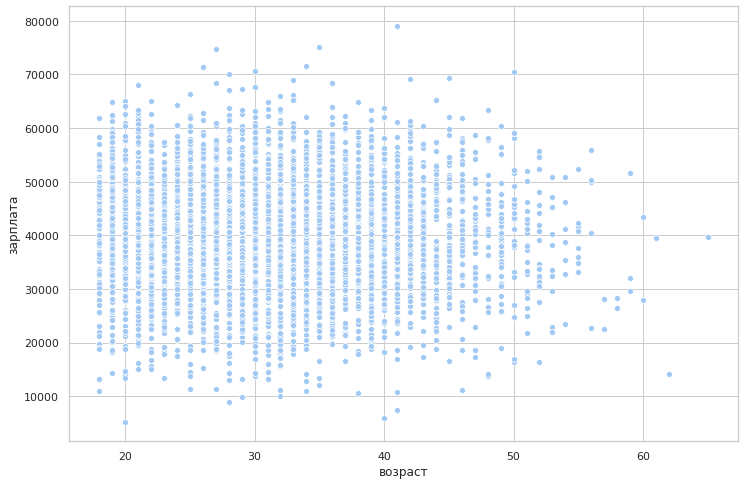

In [6]:
sns.scatterplot(data=df, x='возраст', y='зарплата')

Вроде признаки независимы. Работаем дальше.

## Умножение матриц

Докажем, что умножение матрицы признаков на квадратную обратимую матрицу не изменит результат работы линейной регрессии (на основе которой построена логистическая).

На пальцах это можно доказать словами: умножение матрицы из N признаков на невырожденную квадратную матрицу тождественно переходу к новому базису в том же пространстве. То есть каждый новый столбец признаков (их тоже будет N штук) будет линейной комбинацией исходных признаков. А линейной регрессии именно это и надо.

Для дальнейшего рассмотрения будем считать, что к нашей матрице признаков X уже добавлен столбец единиц, поэтому вектор смещений не учитываем.

Линейная регрессия без модификации признаков:
$$
y_j = X_jw
$$
$$
w = (X^T X)^{-1} X^T y
$$

Здесь нижний индекс $j$ обозначает тестовую выборку, а $Х$ без индекса обозначает обучающую выборку

Модификация признаков будет заключаться в умножении матрицы признаков (и тестовой, и обучающей) на обратимую квадратную матрицу $А$ и получении новых матриц $X'$ и $X'_j$:
$$
X' = XA, \quad X'_j = X_jA
$$

Таким образом, обучение модели на модифицированных признаках будет выглядеть так:
$$
w' = (X'^T X')^{-1} X'^T y = ((XA)^T (XA))^{-1} (XA)^T y
$$

Необходимо доказать, что:
$$
y_j = X_jw = X'_jw'
$$

Нам понадобятся формулы:
$$
(AB)^T = B^T A^T
$$
$$
(AB)^{-1} = B^{-1} A^{-1}
$$

Упростим матрицу весов $w'$:
$$
w' = ((XA)^T (XA))^{-1} (XA)^T y = \\
= (A^T (X^T X) A)^{-1} A^T X^T y = \\
= (A^T ((X^T X) A))^{-1} A^T X^T y = \\
= ((X^T X) A)^{-1} (A^T)^{-1} A^T X^T y = \\
= ((X^T X) A)^{-1} X^T y = \\
= A^{-1}(X^T X)^{-1} X^T y = \\
= A^{-1} w
$$

А теперь доказываем равенство:
$$
X'_j w' = X_j A w' = X_j (A A^{-1}) w = X_j w
$$

Что и требовалось доказать.

**Вывод**

Ответ на вопрос ТЗ "Признаки умножают на обратимую матрицу. Изменится ли качество линейной регрессии? (Её можно обучить заново.)"
- Не изменится

$$
w' = ((XP)^T XP)^{-1} (XP)^T y
$$
$$
w' = (P^T (X^T X) P)^{-1} (XP)^T y
$$
$$
.....
$$

## Алгоритм преобразования

**Алгоритм**

- стандратизуем признаки
- генерируем случайную (значения от 0 до 1) невырожденную квадратную матрицу А размером NxN, где N = количество исходных фич + 1 (помним, что целевой признак не считается фичей)
- проверяем, что матрица обратима. Если нет - повторяем генерацию и проверку
- умножаем стандартизованные признаки на матрицу А

**Обоснование**

По умолчанию нам достаточно сгенерировать невырожденную квадратную матрицу А размером NxN, где N = количество исходных фич + 1 (столбец сдвига), а затем умножить матрицу признаков на нее.

Не любая матрица обратима. Необходимо выполнить проверку.

На первый взгляд, конкретные значения в матрице А нам не очень важны - математика все стерпит.

Но будет нюанс - если просто так выполнить преобразование, то столбцы с большими абсолютными значениями (например, зарплата) могут оказаться явно видимыми, просто с каким-то коэффициентом. Поэтому правильно было бы сначала выполнить стандартизацию, чтобы все признаки имели одинаковый масштаб, а затем уже умножение. Тем более, что стандартизация всегда полезна для линейных моделей.

## Проверка алгоритма

### Генерация обратимой матрицы

По идее можно было бы просто сгенерировать матрицу и потом проверить возможность ее обращения. Но мы попробуем усложнить себе задачу и выполнить "сборку" матрицы из трех: нижней треугольной, диагональной и верхней треугольной.

In [7]:
def gen_matrix(size):
    L = np.tril(np.random.rand(size, size))
    d = np.zeros((size, size), int)
    np.fill_diagonal(d, 1)
    D = np.random.rand(size, size) * d
    U = np.triu(np.random.rand(size, size))
    A = (L @ D) @ U
    return A

Сделаем это все в цикле, чтобы быть уверенными, что матрица обратима. Кроме того, поставим ограничения на значения всех элементов матриц, чтобы они были не слишком маленькими и не слишком большими.

In [8]:
cont = True
while cont:
    size = len(df.columns)
    A = gen_matrix(size)
    try:
        b = np.linalg.inv(A)
        b = np.abs(b)
        if np.min(b) > 1e-2 and np.max(b) < 1e2 and np.min(np.abs(A)) > 1e-2:
            cont = False
    except:
        pass
print(A)

[[0.06848688 0.05228625 0.09241156 0.08531164 0.01169765]
 [0.18407257 0.48509049 0.8210958  0.42389206 0.15347556]
 [0.23336446 0.18738767 0.39523889 0.3491336  0.07170635]
 [0.14216705 0.35917358 0.6278911  0.50759141 0.49753852]
 [0.19767701 0.49863629 0.89078361 0.81184207 1.01264394]]


Вот наша матрица.

### Создание обучающей и тестовой выборок

Мы планируем использовать линейную регрессию, которой не страшно переобучение, поэтому валидационную выборку делать не будем. Сделаем обучающую и тестовую, затем их обе стандартизуем (причем стандартскейлер будем использовать общий, обученный на обучающей выборке).

In [9]:
train = dict()
test = dict()
targets_df = df['страховыевыплаты']
features_df = df[df.columns.drop('страховыевыплаты')]
features = 'features'
targets = 'targets'

train[features], test[features], train[targets], test[targets] = model_selection.train_test_split(
            features_df,
            targets_df, 
            test_size = 0.2, 
            random_state=random_state, 
            shuffle=True,
            )
for i in [train[features], test[features], train[targets], test[targets]]:
    display(i.shape)

(4000, 4)

(1000, 4)

(4000,)

(1000,)

In [10]:
scaler = preprocessing.StandardScaler()
scaler.fit(train[features])
train[features] = scaler.transform(train[features])
test[features] = scaler.transform(test[features])
train[features] = np.hstack((train[features], np.ones((train[features].shape[0], 1))))
test[features] = np.hstack((test[features], np.ones((test[features].shape[0], 1))))
test[features]

array([[ 1.00300451, -0.47633617,  3.51170565, -1.09674864,  1.        ],
       [ 1.00300451,  0.83121836, -1.16472637, -0.18488114,  1.        ],
       [-0.99700449, -1.42728492, -0.3080524 , -0.18488114,  1.        ],
       ...,
       [-0.99700449, -0.71407336, -2.14234255,  0.72698637,  1.        ],
       [-0.99700449,  0.1180068 , -1.69888779,  0.72698637,  1.        ],
       [ 1.00300451,  1.18782414,  1.20372519, -1.09674864,  1.        ]])

### Линейная модель без обработки признаков

Просто обучим и посмотрим.

In [11]:
model = linear_model.LinearRegression(fit_intercept=False)
model.fit(train[features], train[targets])
metrics.r2_score(test[targets], model.predict(test[features]))

0.4458159095923542

### Линейная модель с обработкой признаков

Все то же самое, но массивы фичей умножим матрично на нашу матрицу А.

In [12]:
model = linear_model.LinearRegression(fit_intercept=False)
model.fit(train[features] @ A, train[targets])
metrics.r2_score(test[targets], model.predict(test[features] @ A))

0.4458159095923543

Видим, что метрика осталась прежней - качество модели не изменилось. Значит, идея работает.

## Бонус - распределение признаков "до" и "после"

Вообще говоря, простейший вариант защиты данных - убрать названия столбцов. Но тогда остается уязвимость - по формам распределений можно угадать, что за данные там скрыты, причем стандартизация не поможет.

Посмотрим, как выглядят распределения признаков до и после нашей "Защиты".

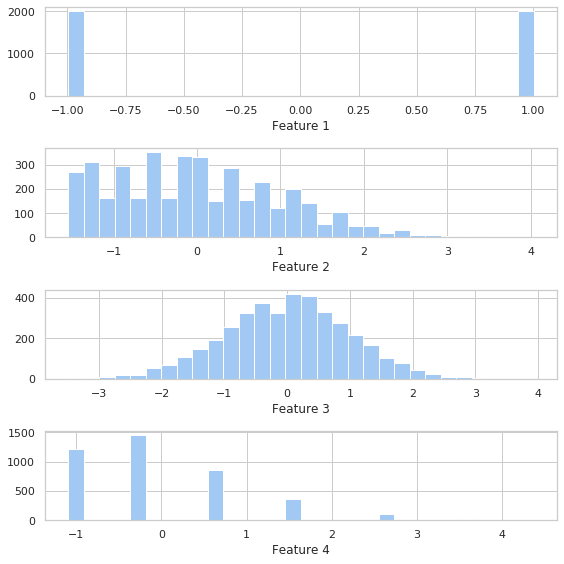

In [13]:
def plots(f):
    fig = plt.figure(figsize=(8, 8))
    for i in range(f.shape[1]):
        plt.subplot(f.shape[1], 1, i+1)
        plt.hist(x=f[:,i], bins=30)
        plt.xlabel(f'Feature {i+1}')
    fig.tight_layout()
    plt.show()

f = train[features][:, :-1]
plots(f)

Наверное, специалист в теме может что-то из этого вытащить.

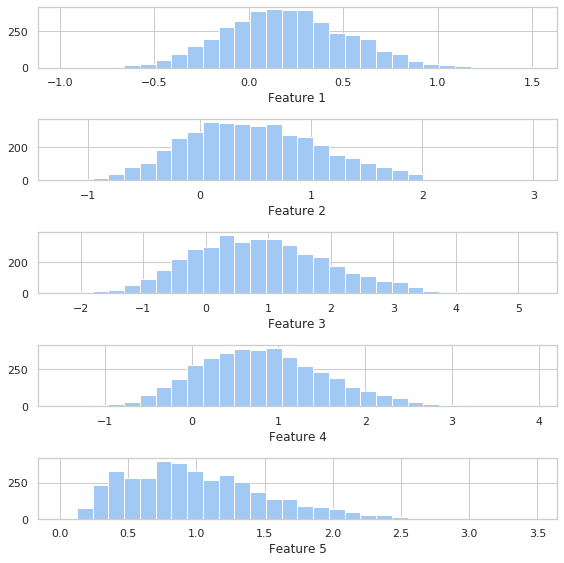

In [14]:
f = (train[features] @ A)
plots(f)

А вот тут все здорово - везде практически нормальные распределения, ничего не понятно. Разве что масштабы разные. Думаю, масштабы можно подкорректировать нормировкой столбцов матрицы А.

## Выводы

- аналитически показано, что умножение матрицы признаков на обратимую матрицу не влияет на результат линейной регрессии
- обучены модели линейной регрессии на исходных признаках и на признаках, умноженных на обратимую матрицу. Показано, что метрика качества не изменилась
- показано, что после умножения исходных признаков на обратимую матрицу полученные признаки не несут в себе очевидного смысла, который мог бы раскрыть личные данные пользователей